## CIS 545 Final Project: Olympic Oracles
#### Jean Park, Ameya Gadkari, Yejin Cha
##### December 15th, 2021
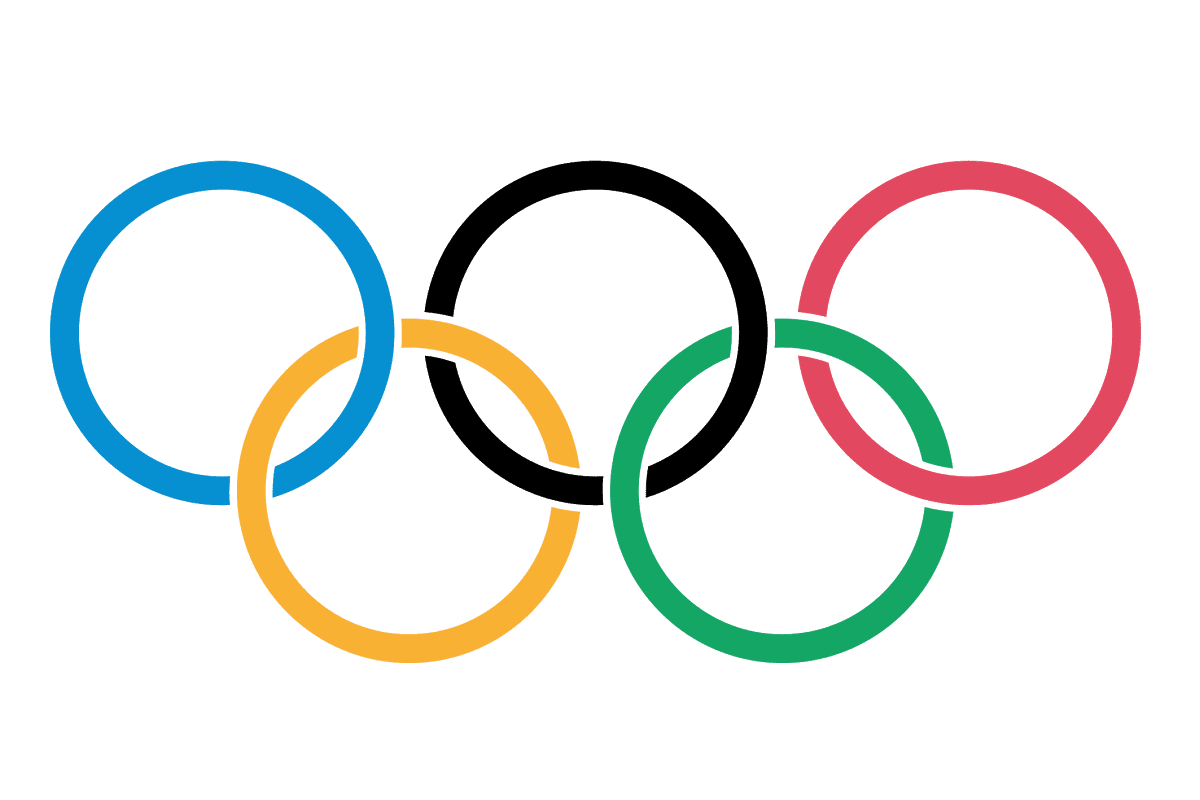


### **Introduction**
Our goal of the project was to analyze the trend in performance of different countries participating in the Olympics throughout history and develop models that can accurately predict future Olympics performance.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install rapidfuzz

     |████████████████████████████████| 893 kB 7.3 MB/s 


In [ ]:
!pip install requests

In [ ]:
import pandas as pd
from rapidfuzz import process, utils, fuzz
from lxml import html
import requests

## 1. Data Loading and Preprocessing


### 1.1 Training Dataset

#### 1.1.1 Loading CSV
We are using `athelete_events.csv` from the [120 years of Olympic history](https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results?select=noc_regions.csv) dataset as our training data. \
It is a historical Olympics data from 1896 - 2016, including both Summer and Winter Olympics. \
Load `athelete_events.csv` as `olympic_df`



In [ ]:
olympic_df = pd.read_csv("/content/drive/Shareddrives/CIS545 Final Project/Dataset/archive/athlete_events.csv")

Since we are only analyzing Summer Olympics data, we dropped rows where 'Season' == 'Winter'.

In [ ]:
# Drop winter
olympic_df = olympic_df[olympic_df.Season == "Summer"]

To better understand our data, we've displayed Argentina's 2008 Olympics data below.


In [ ]:
olympic_df[olympic_df.NOC == "ARG"][olympic_df.Year == 2008]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
1276,716,Lautaro Germn Acosta,M,20.0,168.0,72.0,Argentina,ARG,2008 Summer,2008,Summer,Beijing,Football,Football Men's Football,Gold
2183,1220,Sergio Leonel Agero del Castillo,M,20.0,172.0,74.0,Argentina,ARG,2008 Summer,2008,Summer,Beijing,Football,Football Men's Football,Gold
2620,1467,Mara Magdalena Aicega Amicarelli,F,34.0,165.0,60.0,Argentina,ARG,2008 Summer,2008,Summer,Beijing,Hockey,Hockey Women's Hockey,Bronze
3993,2300,Miguel ngel Albarracn,M,27.0,167.0,64.0,Argentina,ARG,2008 Summer,2008,Summer,Beijing,Judo,Judo Men's Extra-Lightweight,NaN
5447,3074,Julio Alsogaray,M,28.0,180.0,81.0,Argentina,ARG,2008 Summer,2008,Summer,Beijing,Sailing,Sailing Men's One Person Dinghy,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234650,117680,Pablo Ariel Tabachnik,M,30.0,185.0,89.0,Argentina,ARG,2008 Summer,2008,Summer,Beijing,Table Tennis,Table Tennis Men's Singles,NaN
246846,123595,scar Alfredo Ustari,M,22.0,183.0,84.0,Argentina,ARG,2008 Summer,2008,Summer,Beijing,Football,Football Men's Football,Gold
247782,124070,Fabiana Gisela Vallejos,F,23.0,156.0,50.0,Argentina,ARG,2008 Summer,2008,Summer,Beijing,Football,Football Women's Football,NaN
255107,127711,Paola Vukojicic,F,33.0,164.0,58.0,Argentina,ARG,2008 Summer,2008,Summer,Beijing,Hockey,Hockey Women's Hockey,Bronze


Our starting dataset columns had 12 columns:
*   ID
*   Name
*   Sex
*   Age
*   Height
*   Weight
*   Team
*   NOC
*   Games
*   Year
*   Season
*   City

#### 1.1.2 Data Pre-processing
As part of our data pre-processing, we grouped participants by NOC, Year, Sport, and Sex, and calculated the number of participants in the same category. 

In [ ]:
#calculate number of participants in each (sex, sport, country, year)
participant_num = olympic_df.groupby(['NOC', 'Year', 'Sport', 'Sex']).Name.nunique().reset_index().rename(columns = {'Name': 'Participants'})
participant_num

,NOC,Year,Sport,Sex,Participants
0,AFG,1936,Athletics,M,2
1,AFG,1936,Hockey,M,13
2,AFG,1948,Football,M,11
3,AFG,1948,Hockey,M,14
4,AFG,1956,Hockey,M,12
...,...,...,...,...,...
30031,ZIM,2016,Rowing,F,1
30032,ZIM,2016,Rowing,M,1
30033,ZIM,2016,Shooting,M,1
30034,ZIM,2016,Swimming,F,1


We also calculated the average height, weight, and age of the participants in the same NOC, Year, Sport, Sex category to add as new columns in our dataset.

In [ ]:
#calculate average height, weight, age 
height = olympic_df.groupby(['NOC', 'Year', 'Sport', 'Sex']).agg({'Height': lambda x: x.mean(skipna=True)}).reset_index().rename(columns = {'Height': 'avg_height'})
weight = olympic_df.groupby(['NOC', 'Year', 'Sport', 'Sex']).agg({'Weight': lambda x: x.mean(skipna=True)}).reset_index().rename(columns = {'Weight': 'avg_weight'})
age = olympic_df.groupby(['NOC', 'Year', 'Sport', 'Sex']).agg({'Age': lambda x: x.mean(skipna=True)}).reset_index().rename(columns = {'Age': 'avg_age'})

In [ ]:
###new columns: participant number per sex, avg age per sex, avg weight per sex, avg weight per sex
avg_weight_per_sex = olympic_df.groupby(["NOC", "Year", "Sex"]).agg({'Weight': lambda x: x.mean(skipna=True)}).reset_index()
avg_height_per_sex = olympic_df.groupby(["NOC", "Year", "Sex"]).agg({'Height': lambda x: x.mean(skipna=True)}).reset_index()
avg_age_per_sex = olympic_df.groupby(["NOC", "Year", "Sex"]).agg({'Age': lambda x: x.mean(skipna=True)}).reset_index()

In [ ]:
total_weight = olympic_df.groupby(["NOC", "Year"]).agg({'Weight': lambda x: x.mean(skipna=True)}).reset_index().rename(columns = {'Weight': 'total_avg_weight'})
total_height = olympic_df.groupby(["NOC", "Year"]).agg({'Height': lambda x: x.mean(skipna=True)}).reset_index().rename(columns = {'Height': 'total_avg_height'})
total_age = olympic_df.groupby(["NOC", "Year"]).agg({'Age': lambda x: x.mean(skipna=True)}).reset_index().rename(columns = {'Age': 'total_avg_age'})

In [ ]:
avg_weight_per_sex[avg_weight_per_sex.NOC == "ARG"][avg_weight_per_sex.Year == 2008]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,NOC,Year,Sex,Weight
167,ARG,2008,F,63.160714
168,ARG,2008,M,81.460674


`olympic_df` contained information of everyone who participated in the Olympics, so a lot of values were NaN for the `Medal` column. Because we measure performance based on their medal numbers, we removed participants with no medals. Moreover, we cleaned the names of participants and countries.

In [ ]:
#cleaning

#drop participants without medals
olympic_df.dropna(subset=['Medal'], inplace=True)

#clean names 
olympic_df.Name = olympic_df.Name.str.replace(r"\([^()]*\)", "", regex = True)
olympic_df.Name = olympic_df.Name.str.replace(r"\"[^()]*\"", "", regex = True)
olympic_df.Name = olympic_df.Name.str.replace(r" +", " ", regex = True)  
olympic_df.Name = olympic_df.Name.str.strip()

#clean Team name
olympic_df.Team = olympic_df.Team.str.replace(r"-\d", "", regex = True) 

#saving copy for code
olympic_code_df = olympic_df.copy()

Using Xpath, we obtained Host Country's name and their country code. 

In [ ]:
w = requests.get("https://en.wikipedia.org/wiki/Summer_Olympic_Games")
dom_tree = html.fromstring(w.content)
print(dom_tree)
xpath_host_countries = "//*/table[@class='sortable wikitable']/tbody/tr/td[3]/span[@class='flagicon']/a/@title"
xpath_host_year = "//*/table[@class='sortable wikitable']/tbody/tr/td[1]//text()"

host_year = dom_tree.xpath(xpath_host_year)
host_year = [int(x.replace("\n", ""))  for x in host_year if len(x.replace("\n", "")) != 0]

host_countries = dom_tree.xpath(xpath_host_countries)
print("number of host year: ", len(host_year), "number of host countries: ", len(host_countries))

host_country_per_year_df = pd.DataFrame({"Year" : host_year, "Host" : host_countries})
host_country_per_year_df.head()

<Element html at 0x7fcf8bd76050>
number of host year:  32 number of host countries:  32


,Year,Host
0,1896,Kingdom of Greece
1,1900,France
2,1904,United States
3,1908,United Kingdom
4,1912,Sweden


We double-checked to make sure country codes in our dataset and in the Wikipedia page were accurately matching.

In [ ]:

code_df = olympic_df.groupby(["Team", "NOC"]).Year.count().reset_index()
code_df = code_df.drop("Year", axis=1).drop_duplicates()
country_list = code_df.Team.drop_duplicates()
code_list = code_df.NOC.drop
processed_list = [str(x) for x in country_list]
def fmatch (row):
  #return the country name from olympic list id the code match, else use rapidfuzz to do similarity match between gdp and olympic country name
  
  #extract the best match
  match = process.extractOne(row['Host'], processed_list, scorer=fuzz.token_set_ratio, score_cutoff=95)
  if match:
    print("Matched : ", row['Host'], match[0])
    return match[0]
  else:
    print("None matched : ", row['Host'])
    return None

As a result, all matched except for 'United Kingdom' as 'Great Britain' was used in our dataset. We manually replaced 'United Kingdom' as 'Great Britain'.



In [ ]:
host_country_per_year_df["Country"] = host_country_per_year_df.apply(fmatch, axis = 1)

Matched :  Kingdom of Greece Greece
Matched :  France France
Matched :  United States United States
None matched :  United Kingdom
Matched :  Sweden Denmark/Sweden
Matched :  Belgium Belgium
Matched :  France France
Matched :  Netherlands Netherlands
Matched :  United States United States
Matched :  Nazi Germany Germany
None matched :  United Kingdom
Matched :  Finland Finland
Matched :  Australia Australia
Matched :  Italy Italy
Matched :  Japan Japan
Matched :  Mexico Mexico
Matched :  West Germany Germany
Matched :  Canada Canada
Matched :  Soviet Union Soviet Union
Matched :  United States United States
Matched :  South Korea South Korea
Matched :  Spain Spain
Matched :  United States United States
Matched :  Australia Australia
Matched :  Greece Greece
Matched :  China China
None matched :  United Kingdom
Matched :  Brazil Brazil
Matched :  Japan Japan
Matched :  France France
Matched :  United States United States
Matched :  Australia Australia


In [ ]:
#manually fill united kingdom's name
host_country_per_year_df.loc[host_country_per_year_df.Host == "United Kingdom", "Country"] = "Great Britain"

In [ ]:
#merge with olympic dataset to get the matching country code in three digit
host_country_per_year_df = pd.merge(code_df, host_country_per_year_df, left_on = "Team", right_on = "Country", how = "right")
host_country_per_year_df = host_country_per_year_df.drop(["Team", "Host", "Country"], axis = 1).rename(columns = {"NOC" : "Host"})

In [ ]:
olympic_df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
37,15,Arvo Ossian Aaltonen,M,30.0,NaN,NaN,Finland,FIN,1920 Summer,1920,Summer,Antwerpen,Swimming,Swimming Men's 200 metres Breaststroke,Bronze
38,15,Arvo Ossian Aaltonen,M,30.0,NaN,NaN,Finland,FIN,1920 Summer,1920,Summer,Antwerpen,Swimming,Swimming Men's 400 metres Breaststroke,Bronze
41,17,Paavo Johannes Aaltonen,M,28.0,175.0,64.0,Finland,FIN,1948 Summer,1948,Summer,London,Gymnastics,Gymnastics Men's Individual All-Around,Bronze
42,17,Paavo Johannes Aaltonen,M,28.0,175.0,64.0,Finland,FIN,1948 Summer,1948,Summer,London,Gymnastics,Gymnastics Men's Team All-Around,Gold


We measured success of each country based on how many and the kinds of medal they earned. We weighed each medal differently: Gold = 5points, Silver = 3 points, and Bronze = 1 point. Then, we added a 'Medal_Point' column which is the sum of the weights of the medals each country earned in the Olympics.

In [ ]:
olympic_df['Medal_Point'] = 0
olympic_df.loc[olympic_df.Medal == 'Gold', 'Medal_Point'] = 5
olympic_df.loc[olympic_df.Medal == 'Silver', 'Medal_Point'] = 3
olympic_df.loc[olympic_df.Medal == 'Bronze', 'Medal_Point'] = 1

In [ ]:
#compute sum of medal points
partial_df = olympic_df[['NOC', 'Year', 'Sport', 'Sex', 'Medal_Point']]
olympic_medal_sum = partial_df.groupby(['NOC', 'Year', 'Sport', 'Sex']).sum().reset_index()

In [ ]:
olympic_medal_sum.head()

,NOC,Year,Sport,Sex,Medal_Point
0,AFG,2008,Taekwondo,M,1
1,AFG,2012,Taekwondo,M,1
2,AHO,1988,Sailing,M,3
3,ALG,1984,Boxing,M,2
4,ALG,1992,Athletics,F,5


In [ ]:
#add avg height, weight, age, host country per year, participant number per sport
calc_features_df = pd.merge(olympic_medal_sum, height, on = ['NOC', 'Year', 'Sport', 'Sex'], how = "inner")
calc_features_df = pd.merge(calc_features_df, weight, on = ['NOC', 'Year', 'Sport', 'Sex'], how = "inner")
calc_features_df = pd.merge(calc_features_df, age, on = ['NOC', 'Year', 'Sport', 'Sex'], how = "inner")

calc_features_df = pd.merge(calc_features_df, avg_weight_per_sex, on = ['NOC', 'Year', 'Sex'], how = "inner")
calc_features_df = pd.merge(calc_features_df, avg_height_per_sex, on = ['NOC', 'Year', 'Sex'], how = "inner")
calc_features_df = pd.merge(calc_features_df, avg_age_per_sex, on = ['NOC', 'Year', 'Sex'], how = "inner")

calc_features_df = pd.merge(calc_features_df, total_age, on = ['NOC', 'Year'], how = "inner")
calc_features_df = pd.merge(calc_features_df, total_height, on = ['NOC', 'Year'], how = "inner")
calc_features_df = pd.merge(calc_features_df, total_weight, on = ['NOC', 'Year'], how = "inner")

calc_features_df = pd.merge(calc_features_df, host_country_per_year_df, on = ['Year'], how = "inner")
calc_features_df = pd.merge(calc_features_df, participant_num, on = ['NOC', 'Year', 'Sport', 'Sex'], how = "inner")

In [ ]:
#rename columns so that it matches with test dataset
calc_features_df = calc_features_df.rename(columns={"NOC" : "code", "Medal_Point" : "medal_points", "Participants" : "participants", 
                                                    "Sport" : "sport" , "Year": "year", "Sex" : "sex", "Host" : "host"})


In [ ]:
calc_features_df

,code,year,sport,sex,medal_points,avg_height,avg_weight,avg_age,Weight,Height,Age,total_avg_age,total_avg_height,total_avg_weight,host,participants
0,AFG,2008,Taekwondo,M,1,184.500000,65.500000,22.500000,65.000000,179.000000,22.666667,22.500000,179.250000,62.750000,CHN,2
1,ALG,2008,Judo,F,1,160.200000,58.000000,25.000000,63.142857,170.857143,25.000000,25.210526,176.982143,70.821429,CHN,5
2,ALG,2008,Judo,M,3,176.600000,77.800000,28.200000,75.428571,180.657143,25.342857,25.210526,176.982143,70.821429,CHN,5
3,ARG,2008,Basketball,M,12,199.500000,103.000000,28.583333,81.460674,182.415730,28.101124,27.082759,176.875862,74.393103,CHN,12
4,ARG,2008,Cycling,M,10,179.600000,71.100000,31.100000,81.460674,182.415730,28.101124,27.082759,176.875862,74.393103,CHN,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6983,YUG,1980,Judo,M,1,182.166667,81.333333,25.500000,81.080000,184.523179,24.523179,24.318436,183.324022,79.202247,URS,6
6984,YUG,1980,Rowing,M,9,186.285714,81.928571,22.214286,81.080000,184.523179,24.523179,24.318436,183.324022,79.202247,URS,14
6985,YUG,1980,Water Polo,M,33,189.090909,91.000000,26.363636,81.080000,184.523179,24.523179,24.318436,183.324022,79.202247,URS,11
6986,YUG,1980,Wrestling,M,1,175.900000,80.700000,25.800000,81.080000,184.523179,24.523179,24.318436,183.324022,79.202247,URS,10


We added new columns to our dataset: participant number per sex, avg age per sex, avg weight per sex, avg weight per sex

In [ ]:
#group by country code and year
#new columns: participant number per sex, avg age per sex, avg weight per sex, avg weight per sex
import numpy as np
olympic_history_df = calc_features_df
olympic_history_df["medal_sum"] = olympic_history_df.groupby(["code", "year"]).medal_points.transform(np.sum)

olympic_history_df["male_participant"] = (olympic_history_df.assign(participants = olympic_history_df['participants'].where(olympic_history_df['sex'] == 'M'))
                          .groupby(["code", "year"])['participants']
                          .transform('sum'))
olympic_history_df["female_participant"] = (olympic_history_df.assign(participants = olympic_history_df['participants'].where(olympic_history_df['sex'] == 'F'))
                          .groupby(["code", "year"])['participants']
                          .transform('sum'))
olympic_history_df["male_avg_weight"] = olympic_history_df['Weight'].where(olympic_history_df['sex'] == 'M')
olympic_history_df["female_avg_weight"] = olympic_history_df['Weight'].where(olympic_history_df['sex'] == 'F')
olympic_history_df["male_avg_height"] = olympic_history_df['Height'].where(olympic_history_df['sex'] == 'M')
olympic_history_df["female_avg_height"] = olympic_history_df['Height'].where(olympic_history_df['sex'] == 'F')
olympic_history_df["male_avg_age"] = olympic_history_df['Age'].where(olympic_history_df['sex'] == 'M')
olympic_history_df["female_avg_age"] = olympic_history_df['Age'].where(olympic_history_df['sex'] == 'F')

In [ ]:
olympic_history_df = olympic_history_df.sort_values(by = ["year", "code"], ascending = [True, True]).groupby(["code", "year"]).apply(lambda x: x.ffill().bfill()).drop_duplicates(subset=["year", "code"])

In [ ]:
olympic_history_df[olympic_history_df.male_participant != 0][olympic_history_df.male_avg_weight.isna()].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,code,year,sport,sex,medal_points,avg_height,avg_weight,avg_age,Weight,Height,Age,total_avg_age,total_avg_height,total_avg_weight,host,participants,medal_sum,male_participant,female_participant,male_avg_weight,female_avg_weight,male_avg_height,female_avg_height,male_avg_age,female_avg_age
6226,AUS,1896,Athletics,M,10,NaN,NaN,22.0,NaN,NaN,22.000000,22.000000,NaN,NaN,GRE,1,11,2.0,0.0,NaN,NaN,NaN,NaN,22.000000,NaN
6228,AUT,1896,Cycling,M,7,NaN,NaN,23.0,NaN,NaN,21.750000,21.750000,NaN,NaN,GRE,1,15,3.0,0.0,NaN,NaN,NaN,NaN,21.750000,NaN
6230,DEN,1896,Fencing,M,1,NaN,NaN,29.0,NaN,NaN,25.933333,25.933333,NaN,NaN,GRE,1,14,5.0,0.0,NaN,NaN,NaN,NaN,25.933333,NaN
6233,FRA,1896,Athletics,M,4,NaN,NaN,21.0,NaN,NaN,19.789474,19.789474,NaN,NaN,GRE,5,39,11.0,0.0,NaN,NaN,NaN,NaN,19.789474,NaN
6254,HUN,1896,Athletics,M,5,NaN,NaN,24.0,NaN,NaN,22.642857,22.642857,NaN,NaN,GRE,3,16,5.0,0.0,NaN,NaN,NaN,NaN,22.642857,NaN


Our current status of training features are shown below.

In [ ]:
olympic_history_df = olympic_history_df[["code", "year", "female_avg_weight", "male_avg_weight", 
                        "female_avg_height", "male_avg_height",
                        "female_avg_age", "male_avg_age",
                        "male_participant", "female_participant",
                        "medal_sum", "total_avg_age", "total_avg_height", "total_avg_weight", "host"]]
olympic_history_df.head()

,code,year,female_avg_weight,male_avg_weight,female_avg_height,male_avg_height,female_avg_age,male_avg_age,male_participant,female_participant,medal_sum,total_avg_age,total_avg_height,total_avg_weight,host
6226,AUS,1896,NaN,NaN,NaN,NaN,NaN,22.000000,2.0,0.0,11,22.000000,NaN,NaN,GRE
6228,AUT,1896,NaN,NaN,NaN,NaN,NaN,21.750000,3.0,0.0,15,21.750000,NaN,NaN,GRE
6230,DEN,1896,NaN,NaN,NaN,NaN,NaN,25.933333,5.0,0.0,14,25.933333,NaN,NaN,GRE
6233,FRA,1896,NaN,NaN,NaN,NaN,NaN,19.789474,11.0,0.0,39,19.789474,NaN,NaN,GRE
6236,GBR,1896,NaN,102.0,NaN,188.0,NaN,26.526316,10.0,0.0,27,26.526316,188.0,102.0,GRE


To improve the accuracy of out forecast model, we incorporated additional independent variable. Since success in sports has been known to be related to the amount of resource available, we added [gdp data](https://drive.google.com/file/d/1VPI1Rf_iwfGlPA_5FsIh_mAEXpMW3M--/view?usp=sharing).

In [ ]:
#gdp data
gdp_df = pd.read_csv("/content/drive/Shareddrives/CIS545 Final Project/Dataset/gdp/gdp_data.csv")
gdp_df

,Country,Code,Year,GDP-Growth,GDP-Per-Capita,GDP
0,Aruba,ABW,1960,NaN,NaN,NaN
1,Afghanistan,AFG,1960,NaN,NaN,NaN
2,Angola,AGO,1960,NaN,NaN,NaN
3,Albania,ALB,1960,NaN,NaN,NaN
4,Andorra,AND,1960,NaN,NaN,NaN
...,...,...,...,...,...,...
15043,Kosovo,XKX,2016,4.145372,4193.631327,7.738508e+09
15044,"Yemen, Rep.",YEM,2016,-2.701475,667.945437,1.903557e+10
15045,South Africa,ZAF,2016,0.787056,7439.919412,4.298757e+11
15046,Zambia,ZMB,2016,3.794901,1672.345428,2.901824e+10


In [ ]:
gdp_df = gdp_df.rename(columns={"Code" : "code", "Year" : "year", "GDP-Growth" : "gdp_growth", "GDP-Per-Capita" : "gdp_per_capita", "GDP" : "gdp"})

In [ ]:
olympic_history_df = pd.merge(olympic_history_df, gdp_df.drop(columns=['Country']), on = ["code", "year"], how = "left")
olympic_history_df.head()

,code,year,female_avg_weight,male_avg_weight,female_avg_height,male_avg_height,female_avg_age,male_avg_age,male_participant,female_participant,medal_sum,total_avg_age,total_avg_height,total_avg_weight,host,gdp_growth,gdp_per_capita,gdp
0,AUS,1896,NaN,NaN,NaN,NaN,NaN,22.000000,2.0,0.0,11,22.000000,NaN,NaN,GRE,NaN,NaN,NaN
1,AUT,1896,NaN,NaN,NaN,NaN,NaN,21.750000,3.0,0.0,15,21.750000,NaN,NaN,GRE,NaN,NaN,NaN
2,DEN,1896,NaN,NaN,NaN,NaN,NaN,25.933333,5.0,0.0,14,25.933333,NaN,NaN,GRE,NaN,NaN,NaN
3,FRA,1896,NaN,NaN,NaN,NaN,NaN,19.789474,11.0,0.0,39,19.789474,NaN,NaN,GRE,NaN,NaN,NaN
4,GBR,1896,NaN,102.0,NaN,188.0,NaN,26.526316,10.0,0.0,27,26.526316,188.0,102.0,GRE,NaN,NaN,NaN


In [ ]:
olympic_history_df[olympic_history_df.gdp_growth.isna()]

,code,year,female_avg_weight,male_avg_weight,female_avg_height,male_avg_height,female_avg_age,male_avg_age,male_participant,female_participant,medal_sum,total_avg_age,total_avg_height,total_avg_weight,host,gdp_growth,gdp_per_capita,gdp
0,AUS,1896,NaN,NaN,NaN,NaN,NaN,22.000000,2.0,0.0,11,22.000000,NaN,NaN,GRE,NaN,NaN,NaN
1,AUT,1896,NaN,NaN,NaN,NaN,NaN,21.750000,3.0,0.0,15,21.750000,NaN,NaN,GRE,NaN,NaN,NaN
2,DEN,1896,NaN,NaN,NaN,NaN,NaN,25.933333,5.0,0.0,14,25.933333,NaN,NaN,GRE,NaN,NaN,NaN
3,FRA,1896,NaN,NaN,NaN,NaN,NaN,19.789474,11.0,0.0,39,19.789474,NaN,NaN,GRE,NaN,NaN,NaN
4,GBR,1896,NaN,102.000000,NaN,188.000000,NaN,26.526316,10.0,0.0,27,26.526316,188.000000,102.000000,GRE,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242,SUI,2016,60.901639,71.285714,169.426230,177.153846,26.344262,25.692308,23.0,8.0,41,25.953947,174.052632,67.118421,BRA,NaN,NaN,NaN
1247,TPE,2016,58.600000,NaN,163.777778,NaN,24.805556,NaN,0.0,6.0,9,25.134328,169.208955,65.606061,BRA,NaN,NaN,NaN
1251,UAE,2016,NaN,79.875000,NaN,176.000000,NaN,30.000000,3.0,0.0,1,27.833333,171.636364,73.000000,BRA,NaN,NaN,NaN
1255,VEN,2016,64.827586,78.853333,167.275862,181.373333,27.000000,27.657895,8.0,8.0,5,27.476190,177.442308,74.942308,BRA,NaN,NaN,NaN


We handled missing data by simply removing rows with NaN values because that was still enough train to test ratio. Moreover, we dropped 2016 Olympics data from this dataset because we are going to predict that 2016 Olmpics result using our trained model.

In [ ]:
olympic_history_df = olympic_history_df[olympic_history_df.year != 2016]
olympic_history_df = olympic_history_df.dropna(subset = ["gdp", "gdp_growth", "gdp_per_capita"])
print("Number of rows after dropping any row with NaN: ", len(olympic_history_df))

Number of rows after dropping any row with NaN:  509


# Dataset used for prediction (Rio)

Cleaned and preprocessed Rio Olympic 2016, which is used for test dataset. This dataset is different from Olympic history dataset that we cleaned and processed for training model. (We are not using Tokyo 2021 Olympic data because we couldn't get athlete's weight and height data). [athletes.csv](https://drive.google.com/file/d/1VPI1Rf_iwfGlPA_5FsIh_mAEXpMW3M--/view?usp=sharing), [countries.csv](https://drive.google.com/file/d/1XqvPvpmN7vySQDwmlwy5qkphXFwLbaKZ/view?usp=sharing), [events.csv](https://drive.google.com/file/d/1H8w_WmZs0fW4K_YhAnQyGxX3w8D8ubFm/view?usp=sharing)


In [ ]:
#Rio 2016 Olymic
athlete_2016_df = pd.read_csv("/content/drive/Shareddrives/CIS545 Final Project/Dataset/2016/athletes.csv")
countries_2016_df = pd.read_csv("/content/drive/Shareddrives/CIS545 Final Project/Dataset/2016/countries.csv")
events_2016_df = pd.read_csv("/content/drive/Shareddrives/CIS545 Final Project/Dataset/2016/events.csv", encoding = "ISO-8859-1")

In [ ]:
#heights should be CM not M
athlete_2016_df.loc[:, 'height'] = athlete_2016_df.height * 100

In [ ]:
#merge athlete and country data, calculate # of participants per (sex, sport, country)
olympic_2016_df = pd.merge(athlete_2016_df, countries_2016_df, left_on = ['nationality'], right_on=['code'], how = "inner")
participant_num = olympic_2016_df.groupby(['nationality', 'sport', 'sex']).name.count().reset_index().rename(columns = {'name': 'participants'})
avg_height = olympic_2016_df.groupby(['nationality', 'sport', 'sex']).mean().reset_index().rename(columns = {'height': 'avg_height'})
avg_height = avg_height[['nationality', 'sport', 'sex', 'avg_height']]
avg_weight = olympic_2016_df.groupby(['nationality', 'sport', 'sex']).mean().reset_index().rename(columns = {'weight': 'avg_weight'})
avg_weight = avg_weight[['nationality', 'sport', 'sex', 'avg_weight']]
olympic_2016_df = pd.merge(olympic_2016_df, participant_num, on = ['nationality', 'sport', 'sex'], how = "left")
olympic_2016_df = pd.merge(olympic_2016_df, avg_height, on = ['nationality', 'sport', 'sex'], how = "left")
olympic_2016_df = pd.merge(olympic_2016_df, avg_weight, on = ['nationality', 'sport', 'sex'], how = "left")

olympic_2016_df.tail()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze,country,code,population,gdp_per_capita,participants,avg_height,avg_weight
11226,853131625,Zeyad Mater,YEM,male,12/18/91,174.0,73.0,judo,0,0,0,Yemen,YEM,26832215.0,1406.291651,1,174.0,73.0
11227,417884111,Phumlile Ndzinisa,SWZ,female,8/21/92,170.0,57.0,athletics,0,0,0,Swaziland,SWZ,1286970.0,3200.143018,1,170.0,57.0
11228,512714002,Sibusiso Matsenjwa,SWZ,male,5/2/88,180.0,82.0,athletics,0,0,0,Swaziland,SWZ,1286970.0,3200.143018,1,180.0,82.0
11229,315255712,Thea Lafond,DMA,female,4/5/94,173.0,65.0,athletics,0,0,0,Dominica,DMA,72680.0,7116.386392,1,173.0,65.0
11230,365796318,Yordanys Duranona,DMA,male,6/16/88,185.0,83.0,athletics,0,0,0,Dominica,DMA,72680.0,7116.386392,1,185.0,83.0


Since we have date of birth (dob) instead of age for 2016 Rio Olympic data, we are calculating the age by subtracting each athlete's date of birth from Rio Olympic's end date.

In [ ]:
#make age column
from datetime import date, datetime

def calculate_age(dob):
  #Olympic end date: August 21st 2016
  if type(dob) != str:
    return np.nan
  BirthDay = datetime.strptime(str(dob), '%m/%d/%y')
  olympic_end_date = datetime.strptime('Aug 21 2016', '%b %d %Y')
  age = olympic_end_date.year - BirthDay.year - ((olympic_end_date.month, olympic_end_date.day) < (BirthDay.month, BirthDay.day))
  return age

olympic_2016_df["age"] = olympic_2016_df["dob"].apply(calculate_age)

In [ ]:
#make medal_point column : gold is 5, silver is 3, bronze is 1
olympic_2016_df['medal_points'] = olympic_2016_df.gold * 5 + olympic_2016_df.silver * 3 + olympic_2016_df.bronze

In [ ]:
###avg age per sex, avg weight per sex, avg weight per sex
avg_weight_per_sex = olympic_2016_df.groupby(["code", "sex"]).agg({'weight': lambda x: x.mean(skipna=True)}).reset_index()
avg_height_per_sex = olympic_2016_df.groupby(["code", "sex"]).agg({'height': lambda x: x.mean(skipna=True)}).reset_index()
avg_age_per_sex = olympic_2016_df.groupby(["code", "sex"]).agg({'age': lambda x: x.mean(skipna=True)}).reset_index()

In [ ]:
###total avg age per nation
total_weight = olympic_2016_df.groupby(["code"]).agg({'weight': lambda x: x.mean(skipna=True)}).reset_index().rename(columns = {"weight": "total_weight"})
total_height = olympic_2016_df.groupby(["code"]).agg({'height': lambda x: x.mean(skipna=True)}).reset_index().rename(columns = {"height": "total_height"})
total_age = olympic_2016_df.groupby(["code"]).agg({'age': lambda x: x.mean(skipna=True)}).reset_index().rename(columns = {"age": "total_age"})

In [ ]:
#drop non medalists
olympic_2016_df = olympic_2016_df[olympic_2016_df.medal_points != 0]

In [ ]:
#number of sports that each country participated
medal_point_sum = olympic_2016_df.groupby(['code', 'sport', 'sex']).sum().reset_index()[['code', 'sport', 'sex','medal_points']]
olympic_2016_uid_df = olympic_2016_df.groupby(['sex', 'sport', 'code', 'avg_height', 'avg_weight', 'participants', 'population', 'gdp_per_capita']).medal_points.count().reset_index().drop(columns=['medal_points'])
olympic_2016_df = pd.merge(olympic_2016_uid_df, medal_point_sum, on = ['code', 'sport', 'sex'], how = "left")


In [ ]:
olympic_2016_df

,sex,sport,code,avg_height,avg_weight,participants,population,gdp_per_capita,medal_points
0,female,aquatics,AUS,173.148936,64.510638,47,2.378117e+07,56310.962993,67
1,female,aquatics,BLR,171.500000,56.500000,4,9.513000e+06,5740.456495,1
2,female,aquatics,BRA,167.564103,61.307692,39,2.078475e+08,8538.589975,1
3,female,aquatics,CAN,168.307692,60.000000,26,3.585177e+07,43248.529909,24
4,female,aquatics,CHN,173.425926,63.851852,54,1.371220e+09,8027.683810,71
...,...,...,...,...,...,...,...,...,...
445,male,wrestling,RUS,175.076923,83.153846,13,1.440968e+08,9092.580536,24
446,male,wrestling,TUR,176.777778,89.777778,9,7.866583e+07,9125.687590,13
447,male,wrestling,UKR,184.000000,100.000000,6,4.519820e+07,2114.954716,3
448,male,wrestling,USA,176.000000,87.600000,10,3.214188e+08,56115.718426,6


In [ ]:

olympic_2016_df = pd.merge(olympic_2016_df, avg_weight_per_sex, on = ["code", "sex"], how = "inner")
olympic_2016_df = pd.merge(olympic_2016_df, avg_height_per_sex, on = ["code", "sex"], how = "inner")
olympic_2016_df = pd.merge(olympic_2016_df, avg_age_per_sex, on = ["code", "sex"], how = "inner")

olympic_2016_df = pd.merge(olympic_2016_df, total_weight, on = ["code"], how = "inner")
olympic_2016_df = pd.merge(olympic_2016_df, total_height, on = ["code"], how = "inner")
olympic_2016_df = pd.merge(olympic_2016_df, total_age, on = ["code"], how = "inner")

In [ ]:
olympic_2016_df

,sex,sport,code,avg_height,avg_weight,participants,population,gdp_per_capita,medal_points,weight,height,age,total_weight,total_height,total_age
0,female,aquatics,AUS,173.148936,64.510638,47,23781169.0,56310.962993,67,64.570732,172.066667,24.381818,73.426829,178.327751,24.554524
1,female,cycling,AUS,170.214286,63.285714,14,23781169.0,56310.962993,1,64.570732,172.066667,24.381818,73.426829,178.327751,24.554524
2,female,modern pentathlon,AUS,168.000000,55.000000,1,23781169.0,56310.962993,5,64.570732,172.066667,24.381818,73.426829,178.327751,24.554524
3,female,rowing,AUS,180.083333,74.166667,16,23781169.0,56310.962993,5,64.570732,172.066667,24.381818,73.426829,178.327751,24.554524
4,female,rugby sevens,AUS,170.083333,68.416667,12,23781169.0,56310.962993,60,64.570732,172.066667,24.381818,73.426829,178.327751,24.554524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,male,taekwondo,DOM,187.000000,68.000000,2,10528391.0,6468.473492,1,63.473684,172.476190,20.380952,62.481481,171.793103,18.827586
446,male,taekwondo,JOR,178.000000,68.000000,1,7594547.0,4940.045836,5,73.200000,175.142857,24.571429,71.333333,174.750000,24.000000
447,male,taekwondo,NIG,207.000000,98.000000,1,19899120.0,358.958152,3,79.750000,185.750000,21.750000,71.666667,179.166667,20.833333
448,male,weightlifting,ARM,178.200000,112.400000,5,3017712.0,3489.127690,6,86.894737,174.708333,24.750000,78.703704,171.687500,24.250000


We are going to merge the features that we calculated above and generate a clean data that will be used for testing.

In [ ]:
olympic_2016_df["medal_sum"] = olympic_2016_df.groupby(["code"]).medal_points.transform(np.sum)

olympic_2016_df["male_participant"] = (olympic_2016_df.assign(participants = olympic_2016_df['participants'].where(olympic_2016_df['sex'] == 'male'))
                          .groupby(["code"])['participants']
                          .transform('sum'))
olympic_2016_df["female_participant"] = (olympic_2016_df.assign(participants = olympic_2016_df['participants'].where(olympic_2016_df['sex'] == 'female'))
                          .groupby(["code"])['participants']
                          .transform('sum'))
olympic_2016_df["male_avg_weight"] = olympic_2016_df['weight'].where(olympic_2016_df['sex'] == 'male')
olympic_2016_df["female_avg_weight"] = olympic_2016_df['weight'].where(olympic_2016_df['sex'] == 'female')
olympic_2016_df["male_avg_height"] = olympic_2016_df['height'].where(olympic_2016_df['sex'] == 'male')
olympic_2016_df["female_avg_height"] = olympic_2016_df['height'].where(olympic_2016_df['sex'] == 'female')
olympic_2016_df["male_avg_age"] = olympic_2016_df['age'].where(olympic_2016_df['sex'] == 'male')
olympic_2016_df["female_avg_age"] = olympic_2016_df['age'].where(olympic_2016_df['sex'] == 'female')

In [ ]:
olympic_2016_df = olympic_2016_df.sort_values(by = ["code"], ascending = [True]).groupby(["code"]).apply(lambda x: x.ffill().bfill()).drop_duplicates(subset=["code"])
olympic_2016_df = olympic_2016_df.drop(columns=["sport", "sex", "avg_height", "avg_height", "participants", "medal_points"])

In [ ]:
olympic_2016_df.head()

,code,avg_weight,population,gdp_per_capita,weight,height,age,total_weight,total_height,total_age,medal_sum,male_participant,female_participant,male_avg_weight,female_avg_weight,male_avg_height,female_avg_height,male_avg_age,female_avg_age
427,ALG,65.750000,39666519.0,4206.031232,71.920000,177.224138,24.465517,70.316667,175.632353,24.558824,6,12.0,0.0,71.920000,NaN,177.224138,NaN,24.465517,NaN
397,ARG,83.666667,43416755.0,13431.878340,81.985714,182.171233,26.719178,75.709677,177.995516,26.775785,108,32.0,6.0,81.985714,64.298701,182.171233,170.077922,26.719178,26.883117
449,ARM,84.250000,3017712.0,3489.127690,86.894737,174.708333,24.750000,78.703704,171.687500,24.250000,14,13.0,0.0,86.894737,NaN,174.708333,NaN,24.750000,NaN
14,AUS,78.000000,23781169.0,56310.962993,82.282927,184.649038,24.734597,73.426829,178.327751,24.554524,242,125.0,100.0,82.282927,64.570732,184.649038,172.066667,24.734597,24.381818
410,AUT,74.400000,8611088.0,43774.985174,80.648649,183.297297,28.702703,70.521127,177.408451,27.915493,2,5.0,3.0,80.648649,59.500000,183.297297,171.000000,28.702703,27.058824


In [ ]:
olympic_2016_df

,code,avg_weight,population,gdp_per_capita,weight,height,age,total_weight,total_height,total_age,medal_sum,male_participant,female_participant,male_avg_weight,female_avg_weight,male_avg_height,female_avg_height,male_avg_age,female_avg_age
427,ALG,65.750000,39666519.0,4206.031232,71.920000,177.224138,24.465517,70.316667,175.632353,24.558824,6,12.0,0.0,71.920000,NaN,177.224138,NaN,24.465517,NaN
397,ARG,83.666667,43416755.0,13431.878340,81.985714,182.171233,26.719178,75.709677,177.995516,26.775785,108,32.0,6.0,81.985714,64.298701,182.171233,170.077922,26.719178,26.883117
449,ARM,84.250000,3017712.0,3489.127690,86.894737,174.708333,24.750000,78.703704,171.687500,24.250000,14,13.0,0.0,86.894737,NaN,174.708333,NaN,24.750000,NaN
14,AUS,78.000000,23781169.0,56310.962993,82.282927,184.649038,24.734597,73.426829,178.327751,24.554524,242,125.0,100.0,82.282927,64.570732,184.649038,172.066667,24.734597,24.381818
410,AUT,74.400000,8611088.0,43774.985174,80.648649,183.297297,28.702703,70.521127,177.408451,27.915493,2,5.0,3.0,80.648649,59.500000,183.297297,171.000000,28.702703,27.058824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,UAE,84.666667,9156963.0,40438.762934,79.875000,175.750000,30.222222,71.500000,170.500000,27.769231,1,3.0,0.0,79.875000,NaN,175.750000,NaN,30.222222,NaN
379,UKR,67.666667,45198200.0,2114.954716,63.060870,171.456897,25.694915,70.581633,176.084158,25.712195,39,42.0,17.0,81.259259,63.060870,182.325581,171.456897,25.735632,25.694915
225,USA,77.250000,321418820.0,56115.718426,84.031373,185.908046,25.757576,74.311594,178.776786,25.604938,919,195.0,227.0,84.031373,65.966330,185.908046,172.551839,25.757576,25.471947
441,UZB,80.250000,31299500.0,2132.070368,85.891892,178.297872,25.404255,75.385965,175.382353,25.114286,10,20.0,0.0,85.891892,NaN,178.297872,NaN,25.404255,NaN


We are adding host country and year column to have the same features as the training dataset.

In [ ]:
#add year column : 2016
olympic_2016_df['year'] = 2016

In [ ]:
#add host column : BRA
olympic_2016_df['host'] = "BRA"

In [ ]:
olympic_2016_df = pd.merge(olympic_2016_df, gdp_df.drop(columns=["Country"]), on = ["code", "year"], how = "left")

In [ ]:
olympic_2016_df

,code,avg_weight,population,gdp_per_capita_x,weight,height,age,total_weight,total_height,total_age,medal_sum,male_participant,female_participant,male_avg_weight,female_avg_weight,male_avg_height,female_avg_height,male_avg_age,female_avg_age,year,host,gdp_growth,gdp_per_capita_y,gdp
0,ALG,65.750000,39666519.0,4206.031232,71.920000,177.224138,24.465517,70.316667,175.632353,24.558824,6,12.0,0.0,71.920000,NaN,177.224138,NaN,24.465517,NaN,2016,BRA,NaN,NaN,NaN
1,ARG,83.666667,43416755.0,13431.878340,81.985714,182.171233,26.719178,75.709677,177.995516,26.775785,108,32.0,6.0,81.985714,64.298701,182.171233,170.077922,26.719178,26.883117,2016,BRA,-2.514590,10040.130736,4.467306e+11
2,ARM,84.250000,3017712.0,3489.127690,86.894737,174.708333,24.750000,78.703704,171.687500,24.250000,14,13.0,0.0,86.894737,NaN,174.708333,NaN,24.750000,NaN,2016,BRA,5.200000,4406.706434,1.300761e+10
3,AUS,78.000000,23781169.0,56310.962993,82.282927,184.649038,24.734597,73.426829,178.327751,24.554524,242,125.0,100.0,82.282927,64.570732,184.649038,172.066667,24.734597,24.381818,2016,BRA,2.834948,56919.374283,1.422550e+12
4,AUT,74.400000,8611088.0,43774.985174,80.648649,183.297297,28.702703,70.521127,177.408451,27.915493,2,5.0,3.0,80.648649,59.500000,183.297297,171.000000,28.702703,27.058824,2016,BRA,2.729083,50250.045060,4.445640e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,UAE,84.666667,9156963.0,40438.762934,79.875000,175.750000,30.222222,71.500000,170.500000,27.769231,1,3.0,0.0,79.875000,NaN,175.750000,NaN,30.222222,NaN,2016,BRA,NaN,NaN,NaN
69,UKR,67.666667,45198200.0,2114.954716,63.060870,171.456897,25.694915,70.581633,176.084158,25.712195,39,42.0,17.0,81.259259,63.060870,182.325581,171.456897,25.735632,25.694915,2016,BRA,3.335489,3110.194646,1.314673e+11
70,USA,77.250000,321418820.0,56115.718426,84.031373,185.908046,25.757576,74.311594,178.776786,25.604938,919,195.0,227.0,84.031373,65.966330,185.908046,172.551839,25.757576,25.471947,2016,BRA,2.856988,54541.720518,1.784427e+13
71,UZB,80.250000,31299500.0,2132.070368,85.891892,178.297872,25.404255,75.385965,175.382353,25.114286,10,20.0,0.0,85.891892,NaN,178.297872,NaN,25.404255,NaN,2016,BRA,5.132986,2026.540839,6.678546e+10


In [ ]:
olympic_2016_df[olympic_2016_df.gdp_growth.isna()]

,code,avg_weight,population,gdp_per_capita_x,weight,height,age,total_weight,total_height,total_age,medal_sum,male_participant,female_participant,male_avg_weight,female_avg_weight,male_avg_height,female_avg_height,male_avg_age,female_avg_age,year,host,gdp_growth,gdp_per_capita_y,gdp
0,ALG,65.750000,39666519.0,4206.031232,71.920000,177.224138,24.465517,70.316667,175.632353,24.558824,6,12.0,0.0,71.920000,NaN,177.224138,NaN,24.465517,NaN,2016,BRA,NaN,NaN,NaN
6,BAH,74.125000,388019.0,22817.230857,74.222222,182.000000,27.529412,68.875000,176.473684,26.033333,10,16.0,10.0,74.222222,62.000000,182.000000,168.875000,27.529412,24.076923,2016,BRA,NaN,NaN,NaN
12,BUL,63.200000,7177991.0,6993.477360,58.800000,169.476190,24.571429,71.936170,175.580000,25.420000,9,0.0,14.0,NaN,58.800000,NaN,169.476190,NaN,24.571429,2016,BRA,NaN,NaN,NaN
17,CRO,96.571429,4224404.0,11535.829356,93.089552,191.188406,27.695652,86.883721,187.170455,27.318182,81,27.0,7.0,93.089552,65.000000,191.188406,172.578947,27.695652,25.947368,2016,BRA,NaN,NaN,NaN
19,DEN,73.500000,5676002.0,51989.293471,81.195402,186.080460,26.666667,76.453125,182.304688,26.328125,121,38.0,31.0,81.195402,66.390244,186.080460,174.292683,26.666667,25.609756,2016,BRA,NaN,NaN,NaN
25,FIJ,96.461538,892145.0,4960.519954,86.111111,181.057143,22.513514,80.843137,177.229167,23.000000,65,13.0,0.0,86.111111,NaN,181.057143,NaN,22.513514,NaN,2016,BRA,NaN,NaN,NaN
29,GER,68.000000,81413145.0,41313.313995,63.686275,171.598039,25.715686,74.160920,178.995465,25.798186,443,186.0,116.0,83.411255,63.686275,185.362869,171.598039,25.869198,25.715686,2016,BRA,NaN,NaN,NaN
30,GRE,86.130435,10823732.0,18002.230578,82.410714,184.714286,26.857143,72.956522,179.054348,26.354839,21,30.0,16.0,82.410714,58.250000,184.714286,170.250000,26.857143,25.594595,2016,BRA,NaN,NaN,NaN
31,GRN,71.000000,106825.0,9212.020352,71.000000,182.000000,23.400000,71.000000,182.000000,22.714286,3,4.0,0.0,71.000000,NaN,182.000000,NaN,23.400000,NaN,2016,BRA,NaN,NaN,NaN
33,INA,58.800000,257563815.0,3346.487039,57.181818,162.636364,25.090909,66.250000,168.285714,25.035714,16,10.0,7.0,72.117647,57.181818,171.941176,162.636364,25.000000,25.090909,2016,BRA,NaN,NaN,NaN


In [ ]:
sanity_check_df = olympic_2016_df.groupby(['code']).medal_sum.nunique().reset_index()
sanity_check_df[sanity_check_df.medal_sum > 1]

,code,medal_sum


# 2. Feature Selection

Find the best features from our data using correlation matricies and PCA

#### 2.1 EDA - Exploratory Data Analysis

##### **1. Top 5 Countries with total medal points from 1960 to 2012**
##### **2. Correlation Matrix**

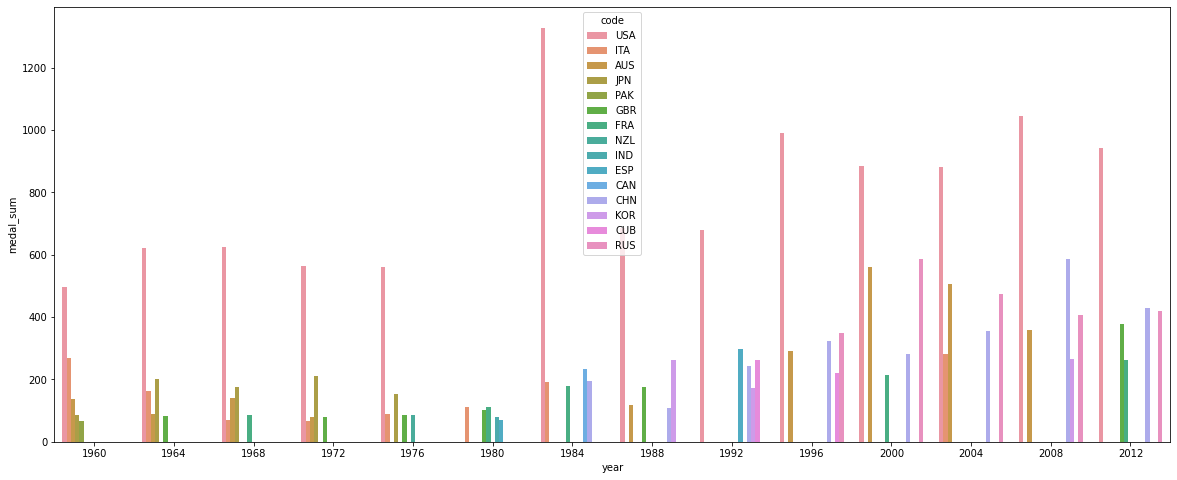

In [ ]:
#plot - top 5 countries with total medal points from 1960 to 2012
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# top_olympic_history_df = olympic_history_df.groupby(['code', 'year']).medal_sum.sum().reset_index()
top_countries_olympic_history_df = olympic_history_df.groupby(['year']).apply(lambda x: x.nlargest(5,['medal_sum'])).reset_index(drop=True)
plt.figure(figsize=(20, 8))
sns.barplot(x='year', y='medal_sum', hue='code', data=top_countries_olympic_history_df)

In [ ]:
# Replaceing all NaN values, which would be for the avg weight, heights, age of male and female participants. 
# NaN occurs for these values when the number of participates for a gender is 0. We know that all the GDP data has to non-NaN as they have been 
# filtered out already

new_olympic_history_df = olympic_history_df.replace(to_replace=np.NaN, value=0)
new_olympic_history_df


,code,year,female_avg_weight,male_avg_weight,female_avg_height,male_avg_height,female_avg_age,male_avg_age,male_participant,female_participant,medal_sum,total_avg_age,total_avg_height,total_avg_weight,host,gdp_growth,gdp_per_capita,gdp
350,ARG,1960,0.000000,73.817391,0.000000,175.504348,0.000000,28.295652,19.0,0.0,10,28.215517,175.431034,73.698276,ITA,-0.852022,5711.179338,1.208089e+11
351,AUS,1960,61.181818,72.472350,166.678571,177.351351,20.410714,25.044643,46.0,22.0,138,24.117857,175.201439,70.189338,ITA,1.295678,19245.410272,2.067342e+11
352,AUT,1960,0.000000,71.965909,0.000000,175.235955,0.000000,27.524476,15.0,0.0,11,25.921466,171.770992,68.276923,ITA,2.648675,13953.950003,9.948977e+10
353,BEL,1960,0.000000,72.203846,0.000000,175.192308,0.000000,27.246154,28.0,0.0,8,26.313333,173.240000,69.603333,ITA,5.212004,14465.977429,1.333847e+11
354,BRA,1960,0.000000,76.428571,0.000000,176.951807,0.000000,25.964706,17.0,0.0,13,25.988372,176.738095,75.681818,ITA,5.216059,3740.433280,2.861967e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166,UGA,2012,0.000000,60.833333,0.000000,173.083333,0.000000,23.583333,8.0,0.0,5,24.062500,170.937500,59.562500,GBR,5.106307,676.337633,2.496507e+10
1167,UKR,2012,61.904412,77.374194,170.880282,179.099379,24.629371,26.068323,56.0,61.0,72,25.391447,175.247525,70.144330,GBR,-6.552619,3123.915572,1.343315e+11
1168,USA,2012,65.938776,83.369942,171.979592,184.627168,25.935860,27.387283,170.0,219.0,942,26.664731,178.330914,74.692308,GBR,2.451973,51015.135477,1.624253e+13
1169,UZB,2012,0.000000,81.911765,0.000000,178.285714,0.000000,25.459459,20.0,0.0,7,25.357143,175.666667,75.269231,GBR,7.179389,1734.362636,5.334501e+10


In [ ]:
# Again, replacing NaN values of columns with 0 and then dropping rows with non-NaN GDP data
olympic_2016_df["female_avg_weight"].fillna(0, inplace=True)
olympic_2016_df["male_avg_weight"].fillna(0, inplace=True)
olympic_2016_df["female_avg_height"].fillna(0, inplace=True)
olympic_2016_df["male_avg_height"].fillna(0, inplace=True)
olympic_2016_df["female_avg_age"].fillna(0, inplace=True)
olympic_2016_df["male_avg_age"].fillna(0, inplace=True)
olympic_2016_df.dropna(subset=["gdp_growth", "gdp_per_capita_y", "gdp"], inplace=True)
olympic_2016_df

,code,avg_weight,population,gdp_per_capita_x,weight,height,age,total_weight,total_height,total_age,medal_sum,male_participant,female_participant,male_avg_weight,female_avg_weight,male_avg_height,female_avg_height,male_avg_age,female_avg_age,year,host,gdp_growth,gdp_per_capita_y,gdp
1,ARG,83.666667,4.341676e+07,13431.878340,81.985714,182.171233,26.719178,75.709677,177.995516,26.775785,108,32.0,6.0,81.985714,64.298701,182.171233,170.077922,26.719178,26.883117,2016,BRA,-2.514590,10040.130736,4.467306e+11
2,ARM,84.250000,3.017712e+06,3489.127690,86.894737,174.708333,24.750000,78.703704,171.687500,24.250000,14,13.0,0.0,86.894737,0.000000,174.708333,0.000000,24.750000,0.000000,2016,BRA,5.200000,4406.706434,1.300761e+10
3,AUS,78.000000,2.378117e+07,56310.962993,82.282927,184.649038,24.734597,73.426829,178.327751,24.554524,242,125.0,100.0,82.282927,64.570732,184.649038,172.066667,24.734597,24.381818,2016,BRA,2.834948,56919.374283,1.422550e+12
4,AUT,74.400000,8.611088e+06,43774.985174,80.648649,183.297297,28.702703,70.521127,177.408451,27.915493,2,5.0,3.0,80.648649,59.500000,183.297297,171.000000,28.702703,27.058824,2016,BRA,2.729083,50250.045060,4.445640e+11
5,AZE,54.666667,9.651349e+06,5496.344640,61.384615,169.357143,25.714286,75.711111,177.535714,25.892857,32,21.0,6.0,81.531250,61.384615,180.261905,169.357143,25.952381,25.714286,2016,BRA,1.412874,5768.992405,5.735725e+10
7,BDI,59.500000,1.117892e+07,277.068309,56.000000,171.000000,25.750000,58.555556,172.000000,23.666667,3,0.0,2.0,0.000000,56.000000,0.000000,171.000000,0.000000,25.750000,2016,BRA,1.599977,210.783570,2.355586e+09
8,BEL,56.500000,1.128572e+07,40324.027766,58.029412,168.205882,26.088235,69.842593,177.537037,25.259259,63,38.0,16.0,75.270270,58.029412,181.824324,168.205882,24.878378,26.088235,2016,BRA,1.437835,46683.157409,5.332182e+11
9,BLR,71.000000,9.513000e+06,5740.456495,64.285714,173.185714,26.957143,72.851240,177.185484,27.233871,24,27.0,13.0,84.607843,64.285714,182.370370,173.185714,27.592593,26.957143,2016,BRA,3.049906,6744.498670,6.397417e+10
10,BRA,90.000000,2.078475e+08,8538.589975,81.324111,182.306513,27.204461,72.693133,176.403361,27.057732,210,107.0,69.0,81.324111,62.441315,182.306513,169.237209,27.204461,26.875000,2016,BRA,1.117579,11026.242161,2.309660e+12
11,BRN,52.555556,1.377237e+06,22600.214098,53.300000,163.400000,21.785714,60.535714,170.785714,23.264706,8,0.0,13.0,0.000000,53.300000,0.000000,163.400000,0.000000,21.785714,2016,BRA,0.052347,31436.948595,1.348526e+10


Up until this point we have cleaned and processed the data so it fits our needs, but we still have some categorical data that needs to be encoded so that our unsupervised learning methods can run properly across the data


Now we will be using the LabelEncoder from sklearn to encode the country code into numbers.

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# TODO code
codes = list(new_olympic_history_df["code"])
codes = codes + ["GER", "URS", "GRE"]
code_encoding=list(le.fit_transform(y=codes))
code_encoding.remove(31)
code_encoding.remove(77)
code_encoding.remove(33)
# code mappings
code_mappings = list(le.classes_)

Here we are using the same encoding for all the country codes and applying it to the Host column as well beacuse the Host column values are also country codes and need to be changed from categorical to numerical

In [ ]:
#add as columns to new_olympic_df 
new_olympic_history_df['code_labels'] = code_encoding
new_olympic_history_df['host_labels'] = le.transform(new_olympic_history_df["host"])

,year,female_avg_weight,male_avg_weight,female_avg_height,male_avg_height,female_avg_age,male_avg_age,male_participant,female_participant,medal_sum,total_avg_age,total_avg_height,total_avg_weight,gdp_growth,gdp_per_capita,gdp,code_labels,host_labels
year,1.000000,0.370134,-0.017084,0.359448,-0.107121,0.410291,-0.100635,-0.025460,0.219448,0.066974,0.164263,0.093163,0.062029,-0.037705,0.140292,0.082999,0.037200,-0.323307
female_avg_weight,0.370134,1.000000,-0.060875,0.996620,-0.138220,0.990044,-0.120544,0.416417,0.450363,0.366637,0.109700,0.068539,0.025800,-0.089019,0.340733,0.268933,-0.024201,-0.144732
male_avg_weight,-0.017084,-0.060875,1.000000,-0.070132,0.959458,-0.074894,0.922254,0.233425,0.155301,0.163868,0.145488,0.366876,0.384648,-0.028423,0.111198,0.103538,0.006124,0.016715
female_avg_height,0.359448,0.996620,-0.070132,1.000000,-0.137784,0.990972,-0.122488,0.416737,0.441616,0.359657,0.090048,0.039258,-0.013535,-0.087238,0.333006,0.267668,-0.023757,-0.139478
male_avg_height,-0.107121,-0.138220,0.959458,-0.137784,1.000000,-0.148019,0.954309,0.193410,0.108771,0.121942,0.050362,0.194587,0.150816,-0.012672,0.027158,0.081294,0.022461,0.059189
female_avg_age,0.410291,0.990044,-0.074894,0.990972,-0.148019,1.000000,-0.121989,0.396859,0.437629,0.347612,0.153297,0.048505,-0.000664,-0.078275,0.342569,0.266143,-0.023170,-0.165093
male_avg_age,-0.100635,-0.120544,0.922254,-0.122488,0.954309,-0.121989,1.000000,0.176272,0.096182,0.104898,0.296106,0.163427,0.155694,-0.007507,0.092338,0.084869,0.016508,0.035166
male_participant,-0.025460,0.416417,0.233425,0.416737,0.193410,0.396859,0.176272,1.000000,0.769344,0.855761,0.017190,0.116581,0.079172,-0.095221,0.312015,0.681199,0.081721,0.018717
female_participant,0.219448,0.450363,0.155301,0.441616,0.108771,0.437629,0.096182,0.769344,1.000000,0.877878,0.033135,0.048588,0.019025,-0.036259,0.266896,0.747850,0.067170,-0.077123
medal_sum,0.066974,0.366637,0.163868,0.359657,0.121942,0.347612,0.104898,0.855761,0.877878,1.000000,0.012538,0.083796,0.065368,-0.048114,0.266800,0.818040,0.148430,-0.021044


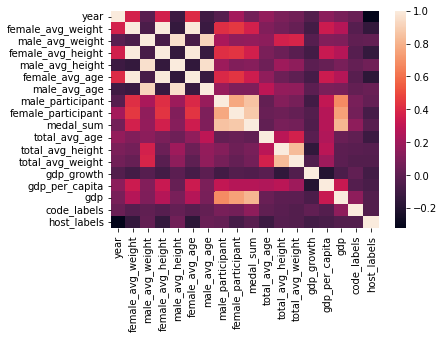

In [ ]:
# train_features = new_olympic_history_df[["code", "year", "sport", "sex","avg_height", "avg_weight",	"participants" ,	"gdp_growth" ,	"gdp_per_capita" ,	"gdp" ]]
# train_labels = new_olympic_history_df["medal_points"]
import seaborn as sns
# building a correlation matric
olympic_corr = new_olympic_history_df.corr()

# Creating a heatmap of the correlation matrix
sns.heatmap(olympic_corr)
# correlation matrix
olympic_corr

#### 2.2 Choosing the features to train our model

The features chosen are

* female_avg_weight
*	male_avg_weight
* female_avg_height
* male_avg_height
* female_avg_age
* male_avg_age
* male_participant
* female_participant
* gdp_growth
* gdp_per_capita
* gdp
* host_labels

These features were all chosen as they were all factors that seems to influence a countries ability to do well at an olympic games. Features such as code or year were left out beacause the specific country or the year should not have an impact on our predictions




Creating the features and labels data structures that our model will run on

In [ ]:
train_features = new_olympic_history_df[['female_avg_weight',	'male_avg_weight',	'female_avg_height',	'male_avg_height',	'female_avg_age',	'male_avg_age',	'male_participant',	'female_participant',	"gdp_growth" ,	"gdp_per_capita" ,	"gdp", "host_labels" ]]
train_labels = new_olympic_history_df["medal_sum"]

Now we need to encode the ordinal data from the Rio data set. Using the same encoder we encode all the country codes and the host column into numerical data

In [ ]:
olympic_2016_df["host_labels"] = le.transform(olympic_2016_df["host"])

# TODO code
code_encoding=le.fit_transform(y=olympic_2016_df["code"])
# code mappings
code_mappings = list(le.classes_)

In [ ]:
olympic_2016_df['code_labels'] = code_encoding

Finally we chose the same features we did from the historical data and pull those into its own dataframe. We also pull the medal sums from the rio data and store it as its own series. This data will be used as testing data to see the accuracy of our models later on

In [ ]:
# rio_features = olympic_2016_df[["code_labels", "year_labels", "sport_labels" ,"sex_labels",	 "avg_height",	"avg_weight",	"participants","gdp_growth",	"gdp_per_capita_y",	"gdp"]]
rio_features = olympic_2016_df[['female_avg_weight',	'male_avg_weight',	'female_avg_height',	'male_avg_height',	'female_avg_age',	'male_avg_age',	'male_participant',	'female_participant',	"gdp_growth" ,	"gdp_per_capita_y" ,	"gdp", "host_labels" ]]
rio_features = rio_features.rename(columns={"gdp_per_capita_y": "gdp_per_capita"})
rio_labels = olympic_2016_df['medal_sum']  

#### 2.3 Dimensionality Reduction with PCA

To make sure that we are only using the minimum number of features necessary we will run PCA over our training data. PCA is a great way to reduce the number of features while still keeping as much variance in the data as possible. 

PCA can also help with the multicollinearity still in the data. 

First we will see how many components we need for our PCA, then we will run it




###### 2.3.1 Finding the number of componenets

First we scale our train data with Standard Scaler as PCA is not scale invariant, then we run our PCA and plot the vairance. Our goal is to use enough features so that we can still have a total explained variance ration of 99.95% or 0.9995

[3.43681200e-01 2.57850600e-01 1.18808255e-01 9.33370644e-02
 7.76501433e-02 5.89977587e-02 2.36908407e-02 1.64667653e-02
 6.21619856e-03 2.24391625e-03 8.48140238e-04 2.09117520e-04]


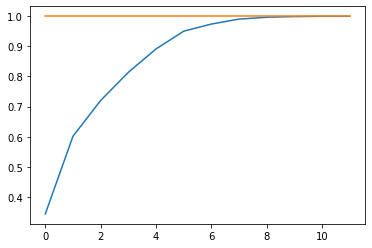

In [ ]:
# Running PCA to find the right number of components

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np


X = StandardScaler().fit_transform(X=train_features)

pca = PCA()
pca.fit_transform(X)

print(pca.explained_variance_ratio_)

# plt.plot(np.arange(0, 10), np.cumsum(pca.explained_variance_ratio_))
# plt.plot(np.arange(0, 10), [0.9995]*10)

plt.plot(np.arange(0, 12), np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.arange(0, 12), [0.9995]*12)
plt.show()


In the graph above we can see an orange line, which represents the amount of explained variance we want (0.9995) and a blue line which represents the total explained variance with a certain number of components. The x axis represents number of components and once we have 8 components we can see that we have at least 0.9995 of expalined variance captured

So now we run PCA with 8 components. Before that, we must scale our features and then fit and transform them



In [ ]:
pca = PCA(n_components=9)
ss = StandardScaler()

ss.fit(X=train_features)
pca_train_features = ss.transform(X=train_features)
pca_rio_features = ss.transform(X=rio_features)

pca.fit(pca_train_features)
pca_train_features = pca.transform(pca_train_features)
pca_rio_features = pca.transform(pca_rio_features)


# 3. Creating and running our regression models



#### 3.1 Linear Regression

Creating a Linear Regression model and training with the train data that has been run through our PCA pipeline. Then it is tested on our Rio Olympics data 

In [ ]:
from sklearn.linear_model import LinearRegression

clf = LinearRegression()


#training with the historical data that has been reduced with PCA.
clf.fit(pca_train_features, train_labels)


# scoring with the rio data. the training features should also be scaled and reduced with PCA 
clf.score(pca_rio_features, rio_labels)

0.8436566339032989

As seen above, we get an R^2 score of 0.843 out of a max of 1. This means that our model performs fairly accurately and can predict accuratly the number of medal points a country will score at a given olympics.




#### 3.2 Random Forest Regression

We also created a Random Forest Regression model to leverage the power of ensemble learning. Our Random forest has 1000 estimators and a max_depth of 150 but had a R^2 Score of 0.925! This significantly out performed our Linear regression model.

We did chose to run our Random Forest on the raw training features rather than the PCA features as we know that Random Forest is scale invariant and good at handling a vast number of features.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# TODO
regressor = RandomForestRegressor(n_estimators = 1000, random_state = 42, max_depth=150)

model = regressor.fit(train_features, train_labels)

score = model.score(rio_features, rio_labels)
print(score)


0.9258377708702931


The Random Forest is also able to show us which features of our data are the most important. Looking at the graph below, we can see that the number of male participans, female participants, and gdp of a country play the most important part with repect to predicting a countries medal sum.

<BarContainer object of 12 artists>

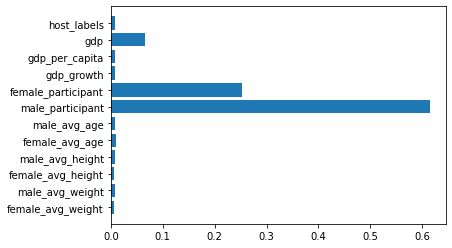

In [ ]:
plt.barh(train_features.columns, regressor.feature_importances_)

### Challenges and Possible Future Steps
Since we were analyzing data from 1896 to 2012, there were some inconsistencies in the names of the countries and countries' current existence that we had to handle. We used rapidfuzz to match country names that are similar or partially match, such as King of Greece and Greece. However, there were a few countries that we could not match using name similarity. For instance, when trying to merge the GDP data and Olympics history data, we had to manually replace 'United Kingdom' with 'Great Britain'.

As host countries may have advantage over other countries, we decided to include host country as a feature. However, the dataset only had hosting cities instead of countries. Thus, we used Xpath to get the names of the countries from the Wikipedia and made a dataset that contained year and host country. The country names in the host dataset and olympic history dataset were a little different, so we used rapidfuzz to match the names. Then, we merged our olympic history dataset and our new host country dataset by the year and country to put the corresponding country code for each host country. 

We used gdp data from 1960 to 2016 and merged it with our olympic data. As we did not have gdp before 1960, we decided to drop the data from 1896 to 1960 as we still had enough rows for our training data. Moreover, some countries did not have gdp data, so we had to either drop them or impute them. Even after dropping countries that did not have gdp data, our train and test dataset ratio was about 0.8 to 0.2. If we want to improve our model in the future, we may consider imputing the NAN values with average gdp of the continent or the region that the country belongs to. 

Another challenge we faced was lack of neccessary information in our Tokyo Olympics dataset such as 'Height' and 'Weight'. This made it difficult to match our training features columns. If we find a dataset that provides us with such data in the future, we can continue testing our model to predict Tokyo Olympics performance. 
